# RAG with a Tool Use approach

In this notebook, we'll look at how we can implement RAG use cases using a tool use approach.

Tool use allows for greater flexibility of accessing data sources, thus unlocking new use cases not possible with a standard RAG approach.

In an enterprise setting with diverse data sources with non-homogeneous formats (structured/semi-structured/unstructured), this approach becomes even more useful.

We'll look at a few example use cases:
- Tool selection
- Multi-step searches
- Structured queries
- Structured data queries
- Action - plotting charts

In [1]:
import cohere
import os
co = cohere.Client(os.getenv("COHERE_API_KEY"))

from tool_def import tools, search_code_examples, search_developer_docs, search_company_information, analyze_evaluation_results

In [2]:
functions_map = {
    "search_code_examples": search_code_examples,
    "search_developer_docs": search_developer_docs,
    "search_company_information": search_company_information,
    "analyze_evaluation_results": analyze_evaluation_results
}

In [3]:
preamble="""## Task & Context
You are an assistant who helps developers use Weights & Biases. The company is also referred to as Wandb or W&B for short. You are equipped with a number of tools that can provide different types of information. If you can't find the information you need from one tool, you should try other tools if there is a possibility that they could provide the information you need."""

# Function to run the assistant over multiple chat turns

In [4]:
model = "command-r-plus"

def run_assistant(message, chat_history=[], show_documents=False):
    # Step 1: Get user message
    print(f"Question:\n{message}")
    print("="*50)

    # Step 2: Generate tool calls (if any)    
    response = co.chat(
        message=message,
        model=model,
        preamble=preamble,
        tools= tools,
        chat_history=chat_history
    )

    while response.tool_calls:
        tool_calls = response.tool_calls
        
        if response.text:
            print("Intermediate response:")
            print(response.text,"\n")
        print("Tool calls:")
        for call in tool_calls:
            print(f"Tool name: {call.name} | Parameters: {call.parameters}")
        print("="*50)
        
        # Step 3: Get tool results
        tool_results = []
        for tc in tool_calls:
            tool_call = {"name": tc.name, "parameters": tc.parameters}
            tool_output = functions_map[tc.name](**tc.parameters)
            tool_results.append({"call": tool_call, "outputs": [tool_output]})
        
        # Step 4: Generate response and citations                
        response = co.chat(
            message="",
            model=model,
            preamble=preamble,
            tools=tools,
            tool_results=tool_results,
            chat_history=response.chat_history
        )

        # Append the current chat turn to the chat history
        chat_history = response.chat_history
        
    # Print final response
    print("Final response:")
    print(response.text)
    print("="*50)
    
    # Print citations (if any)
    if response.citations:
        print("Citations:")
        for citation in response.citations:
            print(citation)
        if show_documents:
            print("\nCited Documents:")
            for document in response.documents:
                print(document)
        print("="*50)
    
    return chat_history

# Tool selection

In [5]:
chat_history = run_assistant("Where can I find the output of a run")
# Chooses search_developer_docs

Question:
Where can I find the output of a run
Intermediate response:
I will search for where the output of a run can be found. 

Tool calls:
Tool name: search_developer_docs | Parameters: {'query': 'where to find output of run'}
Final response:
To view the output of a run, navigate to the W&B App UI, select the relevant project, and then choose the run from the 'Runs' table.
Citations:
start=29 end=55 text='navigate to the W&B App UI' document_ids=['search_developer_docs:0:2:0']
start=57 end=84 text='select the relevant project' document_ids=['search_developer_docs:0:2:0']
start=95 end=131 text="choose the run from the 'Runs' table" document_ids=['search_developer_docs:0:2:0']


In [6]:
chat_history = run_assistant("Where are Wandb's offices")
# Chooses search_company_information

Question:
Where are Wandb's offices
Intermediate response:
I will search for 'Wandb offices' to find the answer to the user's request. 

Tool calls:
Tool name: search_company_information | Parameters: {'query': 'Wandb offices'}
Final response:
Weights & Biases have offices in San Francisco, Berlin, Tokyo, and London.
Citations:
start=33 end=73 text='San Francisco, Berlin, Tokyo, and London' document_ids=['search_company_information:0:2:0']


# Multi-step searches

In [25]:
chat_history = run_assistant("What's that feature to automate hyperparameter search? Do you have some code examples?")
# Does two steps of tool use
# Returns two code examples - Selecting Hyperparameters with Sweeps (Keras) & Create a hyperparameter search with W&B PyTorch integration

Question:
What's that feature to automate hyperparameter search? Do you have some code examples?
Intermediate response:
I will search for the feature to automate hyperparameter search and then search for code examples for that feature. 

Tool calls:
Tool name: search_developer_docs | Parameters: {'query': 'automate hyperparameter search'}
Intermediate response:
I have found that the feature to automate hyperparameter search is called W&B Sweeps. Now I will search for code examples for W&B Sweeps. 

Tool calls:
Tool name: search_code_examples | Parameters: {'language': 'en', 'query': 'W&B Sweeps'}
Final response:
The feature to automate hyperparameter search is called W&B Sweeps. Here are some code examples:
- Selecting Hyperparameters with Sweeps (Keras)
- Create a hyperparameter search with W&B PyTorch integration
Citations:
start=56 end=66 text='W&B Sweeps' document_ids=['search_developer_docs:0:2:0']
start=99 end=143 text='Selecting Hyperparameters with Sweeps (Keras' document_ids=[

# Structured queries

In [7]:
chat_history = run_assistant("Any jupyter notebook for Data Versioning with Artifacts?")
# Searches for file_type = ipynb

Question:
Any jupyter notebook for Data Versioning with Artifacts?
Intermediate response:
I will search for Jupyter notebooks for Data Versioning with Artifacts. 

Tool calls:
Tool name: search_code_examples | Parameters: {'file_type': 'ipynb', 'language': {'language': 'en'}, 'query': 'Data Versioning with Artifacts'}
Final response:
Sorry, I couldn't find any Jupyter notebooks for Data Versioning with Artifacts.


In [8]:
chat_history = run_assistant("Any code examples for data versioning with artifacts?")
# Doesn't need to specify file_type as it's a generic question

Question:
Any code examples for data versioning with artifacts?
Intermediate response:
I will search for code examples for data versioning with artifacts. 

Tool calls:
Tool name: search_code_examples | Parameters: {'language': 'en', 'query': 'data versioning with artifacts'}
Final response:
Yes, there is a code example for data versioning with artifacts in PyTorch.
Citations:
start=16 end=74 text='code example for data versioning with artifacts in PyTorch' document_ids=['search_code_examples:0:2:0']


In [11]:
# English: Code examples on how to visualize datasets
chat_history = run_assistant("データセットを視覚化する方法のコード例?")
# Searches for language = ja
# Returns a code example in Japanese about tables

Question:
データセットを視覚化する方法のコード例?
Intermediate response:
I will search for code examples in Japanese that visualise datasets. 

Tool calls:
Tool name: search_code_examples | Parameters: {'language': 'ja', 'query': 'データセットの可視化'}
Final response:
データセットを視覚化するには、テーブルを使用できます。
Citations:
start=15 end=19 text='テーブル' document_ids=['search_code_examples:0:2:0']


# Structured data queries

In [13]:
chat_history = run_assistant("What's the average evaluation score in run A")
# Answer: 0.63

Question:
What's the average evaluation score in run A


Python REPL can execute arbitrary code. Use with caution.


Intermediate response:
I will use the analyze_evaluation_results tool to find the average evaluation score in run A. 

Tool calls:
Tool name: analyze_evaluation_results | Parameters: {'code': "import pandas as pd\n\ndf = pd.read_csv('evaluation_results.csv')\n\n# Filter the dataframe to only include run A\ndf_run_a = df[df['run'] == 'A']\n\n# Calculate the average score for run A\naverage_score_run_a = df_run_a['score'].mean()\n\nprint(f'The average evaluation score in run A is: {average_score_run_a}')"}


/Users/meor/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Final response:
The average evaluation score in run A is **0.63**.
Citations:
start=42 end=47 text='*0.63' document_ids=['analyze_evaluation_results:0:2:0']


In [24]:
chat_history = run_assistant("What's the latency of the highest-scoring run for the summarize_article use case?")
# Answer: 4.8

Question:
What's the latency of the highest-scoring run for the summarize_article use case?
Intermediate response:
I will use the analyze_evaluation_results tool to find the highest-scoring run for the summarize_article use case and its latency. 

Tool calls:
Tool name: analyze_evaluation_results | Parameters: {'code': 'import pandas as pd\n\ndf = pd.read_csv(\'evaluation_results.csv\')\n\n# Filter for summarize_article use case\ndf_use_case = df[df[\'usecase\'] == \'summarize_article\']\n\n# Get the highest-scoring run\nhighest_scoring_run = df_use_case.loc[df_use_case[\'score\'].idxmax()]\n\n# Get the latency of the highest-scoring run\nlatency = highest_scoring_run[\'latency\']\n\nprint(f"The latency of the highest-scoring run for the summarize_article use case is {latency} seconds.")'}
Final response:
The latency of the highest-scoring run for the summarize_article use case is 4.8 seconds.
Citations:
start=77 end=88 text='4.8 seconds' document_ids=['analyze_evaluation_results:0:2:0

In [21]:
chat_history = run_assistant("Which use case uses the least amount of tokens on average? Show the comparison in a table.")
# Answer: extract_names (106.25), draft_email (245.75), summarize_article (355.75)

Question:
Which use case uses the least amount of tokens on average? Show the comparison in a table.
Intermediate response:
I will use the 'analyze_evaluation_results' tool to write code that will answer the user's request. 

Tool calls:
Tool name: analyze_evaluation_results | Parameters: {'code': "import pandas as pd\n\ndf = pd.read_csv('evaluation_results.csv')\n\n# Group by usecase and calculate average tokens\navg_tokens_by_usecase = df.groupby('usecase')['tokens'].mean()\n\n# Sort the average tokens in ascending order\navg_tokens_by_usecase_sorted = avg_tokens_by_usecase.sort_values()\n\n# Create a table from the sorted values\nprint(avg_tokens_by_usecase_sorted)"}
Final response:
The 'extract_names' use case uses the least amount of tokens on average. Here is a table showing the comparison:

| Use case | Average tokens |
| --- | --- |
| extract_names | 106.25 |
| draft_email | 245.75 |
| summarize_article | 355.75 |
Citations:
start=4 end=18 text="'extract_names" document_ids=['a

# Action - plotting charts

Question:
Create a plot of the average evaluation score for each temperature setting for the extract_names use case.
Intermediate response:
I will use the 'analyze_evaluation_results' tool to generate code that will create a plot of the average evaluation score for each temperature setting for the extract_names use case. 

Tool calls:
Tool name: analyze_evaluation_results | Parameters: {'code': "import pandas as pd\n\ndf = pd.read_csv('evaluation_results.csv')\n\n# Filter the dataframe for the extract_names use case\ndf_extract_names = df[df['usecase'] == 'extract_names']\n\n# Group the data by temperature and calculate the average score\navg_scores = df_extract_names.groupby('temperature')['score'].mean()\n\n# Plot the average scores\navg_scores.plot(kind='bar', title='Average Evaluation Score by Temperature for extract_names Use Case')\n"}
Final response:
Unfortunately, I was unable to generate the code to create the plot. Please try again later.


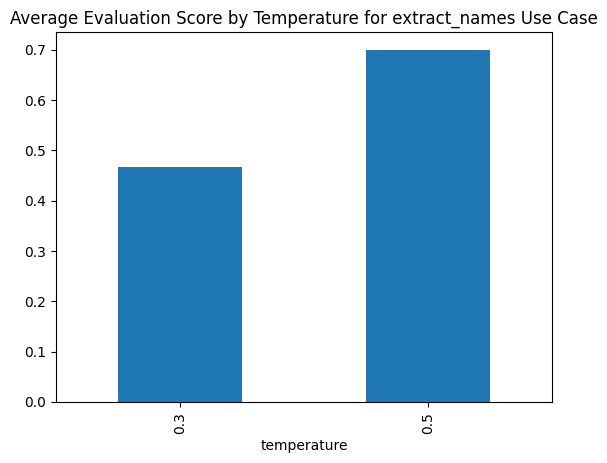

In [15]:
chat_history = run_assistant("Create a plot of the average evaluation score for each temperature setting for the extract_names use case.")
# Answer: temp 0.3 (0.46 avg score) vs temp 0.5 (0.7 avg score). And draws a plot